[20220924]

# 2. Model 7

After Preparation ready. Build and train the model in here. its using LSTM one layer. with data gen5

## Goal
Find patterns on the features for target

## Plan
Checklist what will be done on the notebook :

        [ ] Get Data
        [ ] Modelling
        [ ] Evaluation

In [1]:
import yaml
import pandas as pd
import matplotlib.pyplot as plt
import os
import joblib
from statsmodels.tsa.arima.model import ARIMA
import sys
sys.path.insert(1,'../../src/')

## import myfunc inside src folder
from ramal import eval_model, jampi

In [2]:
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator
from keras import metrics, optimizers
import keras
import tensorflow as tf
from keras.models import load_model

from sklearn.model_selection import train_test_split

2022-09-29 13:19:37.744032: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-29 13:19:37.744090: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/usr/local/lib/python3.7/site-packages/requests/__init__.py:104: RequestsDependencyWarning: urllib3 (1.26.11) or chardet (5.0.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  RequestsDependencyWarning)


In [3]:
with open("../../config.yaml", "r") as f:
    config = yaml.load(f, Loader=yaml.FullLoader)

PATH_RAW = config['path']['raw']
PATH_INTERIM = config['path']['interim']
PATH_PROCESSED = config['path']['processed']
# PATH_MODEL = config['path']['artifact']+os.getcwd().split('\\')[-1]+'/'
PATH_MODEL = config['path']['artifact']+'iteration_3'+'/'
PATH_UDF = config['path']['udf']

## Get Data

In [4]:
Xt, yt, Xo, yo = joblib.load(PATH_INTERIM+'feat_target_gen5_iter3.pkl')
Xt = Xt.astype("float32")
yt = yt.astype("float32")

Xo = Xo.astype("float32")
yo = yo.astype("float32")

In [5]:
Xt.shape

(409713, 15, 3)

In [6]:
yt.shape

(409713, 1)

In [7]:
SEQ = Xt.shape[1]

In [8]:
## not the best way to split time series dataset
x_tr, x_test, y_tr, y_test = train_test_split(
    Xt, yt, test_size=0.25, random_state=42)

x_train, x_val, y_train, y_val = train_test_split(
    x_tr, y_tr, test_size=0.2, random_state=42)

## Model 1

In [9]:
# os.environ["CUDA_VISIBLE_DEVICES"] 

In [10]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


2022-09-29 13:20:42.537842: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-09-29 13:20:42.537923: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-09-29 13:20:42.537945: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (62cd00eaf0b9): /proc/driver/nvidia/version does not exist


In [12]:
mod_ts = Sequential()
mod_ts.add(LSTM(256, input_shape=(SEQ, 3), return_sequences=True))
mod_ts.add(LSTM(64))
mod_ts.add(Dense(64))
mod_ts.add(Dense(32))
mod_ts.add(Dense(32))
mod_ts.add(Dense(1))


In [13]:
early_stop = keras.callbacks.EarlyStopping(
        monitor='val_loss',mode='min', patience=6) 

check_p = keras.callbacks.ModelCheckpoint(
        filepath=PATH_MODEL+'ws_data_model7_iter3.h5',
        monitor='val_loss',
        mode='min',
        save_best_only=True)

opt = tf.keras.optimizers.Adam(learning_rate=0.00035)

mod_ts.compile(loss='mean_squared_error', optimizer=opt, metrics=[
        tf.keras.metrics.RootMeanSquaredError(name='the_rmse'),
        tf.keras.metrics.MeanAbsolutePercentageError(name='the_mape'),
    ])

In [14]:
history = mod_ts.fit(
    x_train,
    y_train,
    batch_size=128,
    epochs=50,
    
    # We pass some validation for
    # monitoring validation loss and metrics
    # at the end of each epoch
    validation_data=(x_val, y_val),
    callbacks=[early_stop,check_p]
)

Epoch 1/50
1921/1921 [==============================] - 198s 102ms/step - loss: 0.6913 - the_rmse: 0.8315 - the_mape: 132792.3594 - val_loss: 0.5968 - val_the_rmse: 0.7725 - val_the_mape: 183711.0156
Epoch 2/50
1921/1921 [==============================] - 185s 96ms/step - loss: 0.5672 - the_rmse: 0.7531 - the_mape: 143794.6406 - val_loss: 0.5462 - val_the_rmse: 0.7391 - val_the_mape: 217581.1562
Epoch 3/50
1921/1921 [==============================] - 208s 108ms/step - loss: 0.5349 - the_rmse: 0.7313 - the_mape: 147894.6875 - val_loss: 0.5184 - val_the_rmse: 0.7200 - val_the_mape: 173153.0156
Epoch 4/50
1921/1921 [==============================] - 197s 102ms/step - loss: 0.5143 - the_rmse: 0.7171 - the_mape: 138705.2656 - val_loss: 0.5133 - val_the_rmse: 0.7164 - val_the_mape: 232870.3594
Epoch 5/50
1921/1921 [==============================] - 191s 99ms/step - loss: 0.5010 - the_rmse: 0.7078 - the_mape: 131805.5469 - val_loss: 0.5106 - val_the_rmse: 0.7145 - val_the_mape: 235499.0625
Ep

## Eval

<AxesSubplot:>

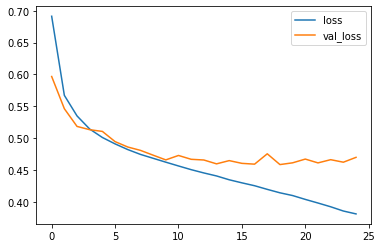

In [15]:
df_epoch_hist = pd.DataFrame(history.history)
df_epoch_hist[['loss','val_loss']].plot()

In [16]:
# depd = {'auc_1' : metrics.AUC}
model_load = load_model(PATH_MODEL + 'ws_data_model7_iter3.h5',compile=False)

In [17]:
model_load.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 15, 256)           266240    
                                                                 
 lstm_3 (LSTM)               (None, 64)                82176     
                                                                 
 dense_3 (Dense)             (None, 64)                4160      
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dense_5 (Dense)             (None, 32)                1056      
                                                                 
 dense_6 (Dense)             (None, 1)                 33        
                                                                 
Total params: 355,745
Trainable params: 355,745
Non-tr

In [18]:
model_load.compile(loss='mean_squared_error', optimizer=opt, metrics=[
        tf.keras.metrics.RootMeanSquaredError(name='the_rmse'),
        tf.keras.metrics.MeanAbsolutePercentageError(name='the_mape'),
    ])

In [19]:
model_load.evaluate(x_test,y_test)

3201/3201 [==============================] - 55s 17ms/step - loss: 0.4631 - the_rmse: 0.6805 - the_mape: 112619.5938


[0.46311166882514954, 0.6805230975151062, 112619.59375]

In [20]:
model_load.evaluate(Xo,yo)

521/521 [==============================] - 9s 17ms/step - loss: 0.4611 - the_rmse: 0.6791 - the_mape: 106956.2344


[0.46114155650138855, 0.6790740489959717, 106956.234375]